# Metropolis-Hastings sampling of MLP weights using iris data

Sampling the weights of a multi-layer perceptron (MLP) using the iris data and Metropolis-Hastings algorithm.

In [1]:
## Import packages

import numpy as np

import torch

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.data import Iris
from eeyore.models import mlp
from eeyore.kernels import NormalTransitionKernel
from eeyore.mcmc import MetropolisHastings

from timeit import default_timer as timer
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# iris_classe_names = {b'Iris-setosa': 0, b'Iris-versicolor': 1, b'Iris-virginica': 2}

# iris_original_data = np.genfromtxt(
#     'iris.csv',
#     delimiter=',',
#     dtype=5*[np.float64],
#     converters={4: lambda x: iris_classe_names[x]}
# )

# iris_measurements = np.empty([150, 4])
# iris_classes = np.empty(150)

# for i in range(len(iris_original_data)):
#     sepal_length, sepal_width, petal_length, petal_width, iris_class = iris_original_data[i]
#     iris_measurements[i, :] = sepal_length, sepal_width, petal_length, petal_width
#     iris_classes[i] = iris_class
    
# iris_measurements = torch.from_numpy(iris_measurements)
# iris_classes = torch.from_numpy(iris_classes)

In [3]:
## Load iris data

iris = Iris()
dataloader = DataLoader(iris, batch_size=150)

In [4]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[4, 2, 3])
model = mlp.MLP(hparams=hparams, dtype=torch.float64)
model.prior = Normal(
    torch.zeros(model.num_params(), dtype=model.dtype),
    np.sqrt(3)*torch.ones(model.num_params(), dtype=model.dtype)
)

In [5]:
## Setup Metropolis-Hastings sampler

theta0 = model.prior.sample()
num_params = model.num_params()
kernel = NormalTransitionKernel(torch.zeros(num_params, dtype=torch.float64), np.sqrt(0.025)*torch.ones(num_params, dtype=torch.float64))
sampler = MetropolisHastings(model, theta0, dataloader, kernel)

In [6]:
## Run Metropolis-Hastings sampler

start_time = timer()

sampler.run(num_iterations=11000, num_burnin=1000)

end_time = timer()
print("Time taken: {}".format(timedelta(seconds=end_time-start_time)))

Time taken: 0:00:17.069128


In [7]:
## Compute acceptance rate

sampler.chain.acceptance_rate()

0.14139999449253082

In [8]:
## Compute Monte Carlo mean

sampler.chain.mean()

tensor([-2.1517, -2.9344,  3.0585,  5.4813,  1.1545,  1.3011, -3.6312, -1.0612,
        -1.3964,  0.1249, -2.8937,  6.0831, -4.9708, -5.1619,  5.8546, -1.6649,
        -2.7517,  2.1494, -2.8952], dtype=torch.float64)

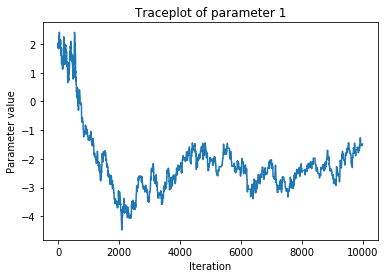

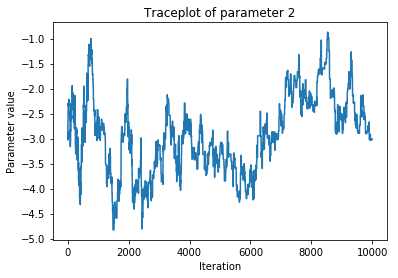

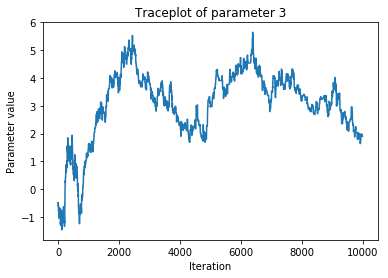

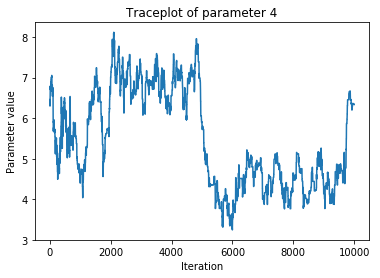

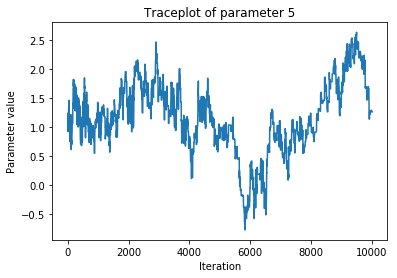

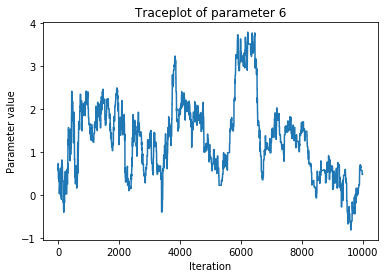

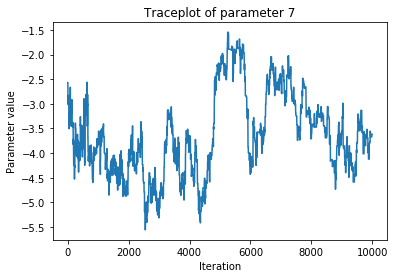

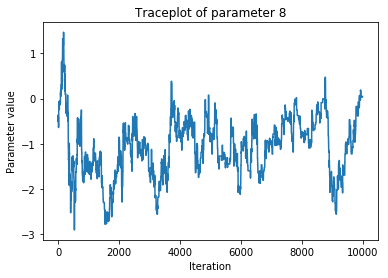

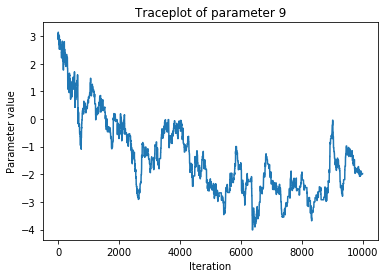

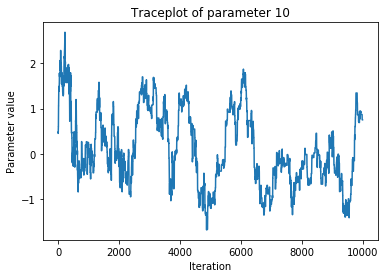

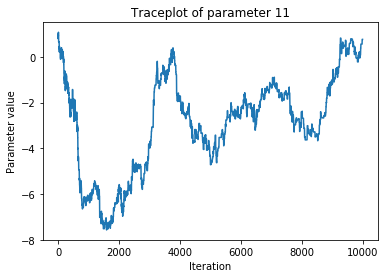

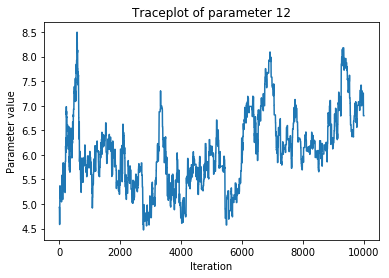

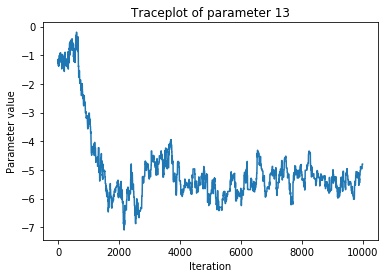

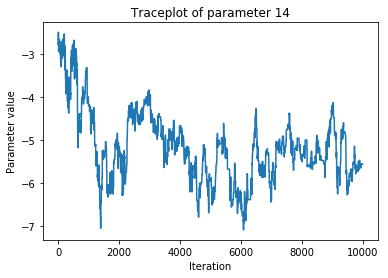

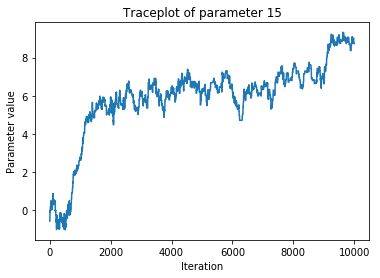

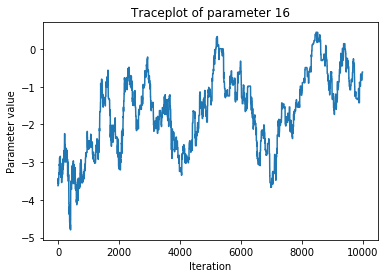

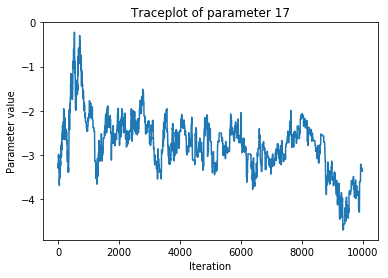

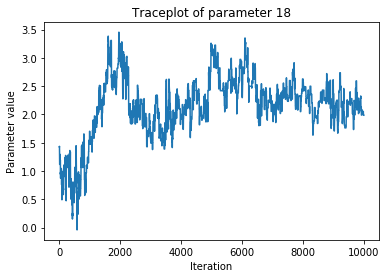

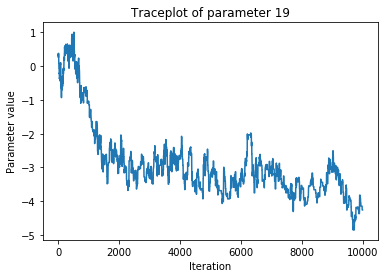

In [9]:
## Plot traces of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter {}'.format(i+1))

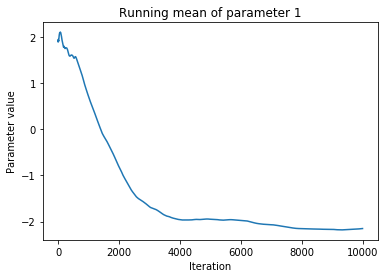

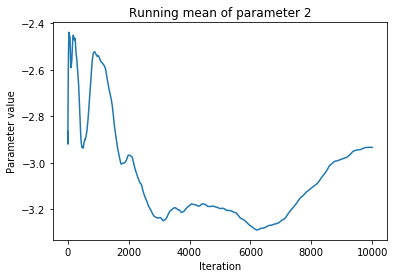

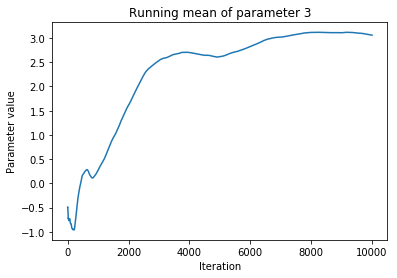

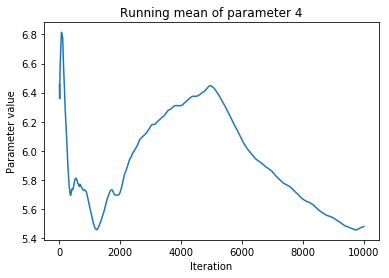

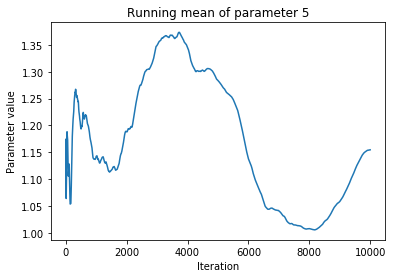

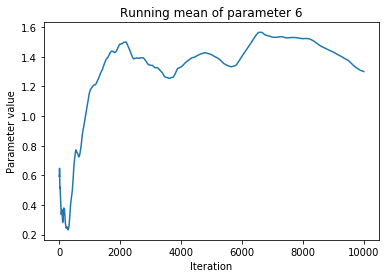

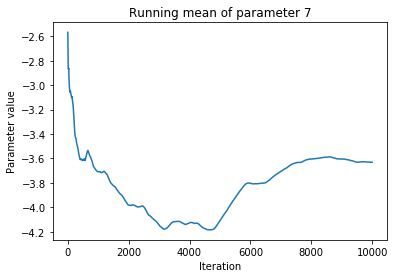

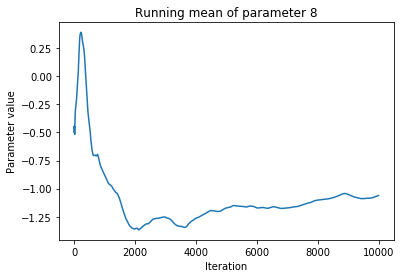

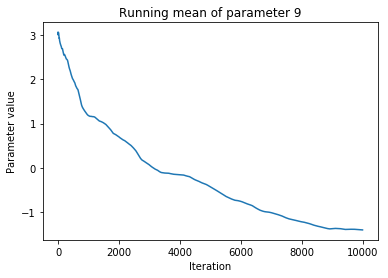

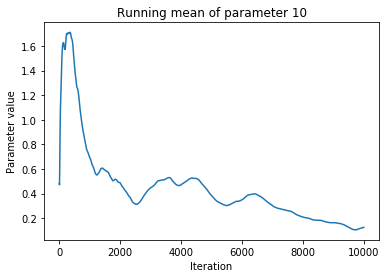

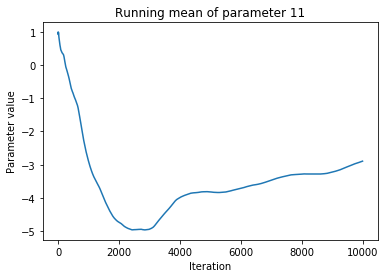

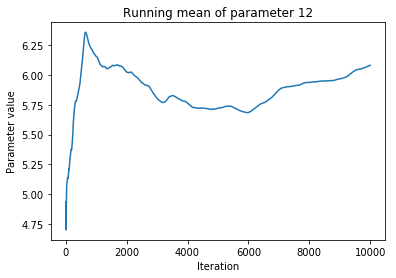

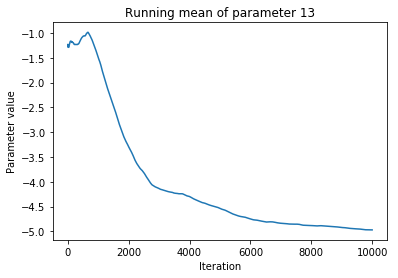

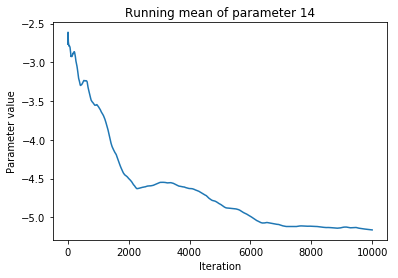

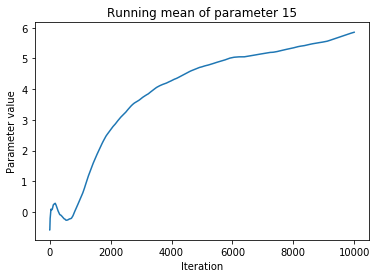

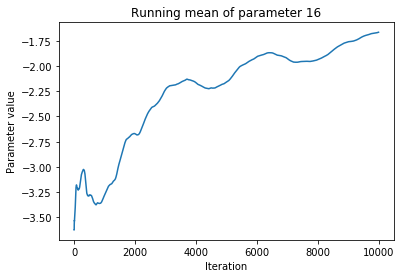

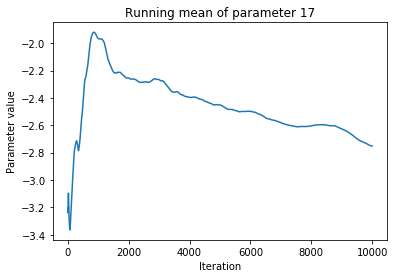

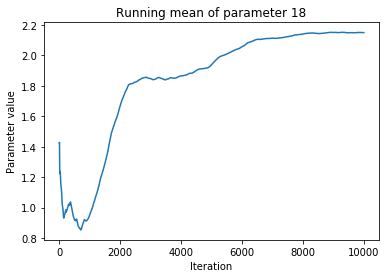

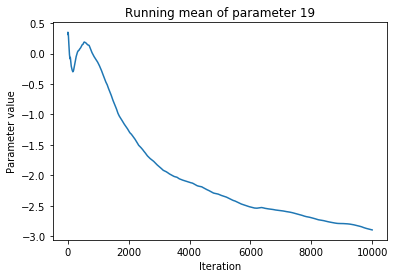

In [10]:
## Plot running means of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    chain_mean = torch.empty(len(chain))
    chain_mean[0] = chain[0]
    for j in range(1, len(chain)):
        chain_mean[j] = (chain[j]+j*chain_mean[j-1])/(j+1)
        
    plt.figure()
    sns.lineplot(range(len(chain)), chain_mean)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Running mean of parameter {}'.format(i+1))

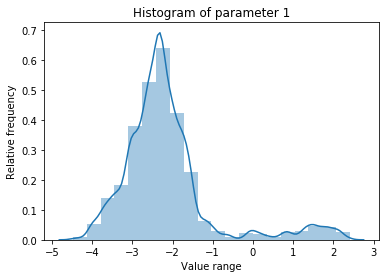

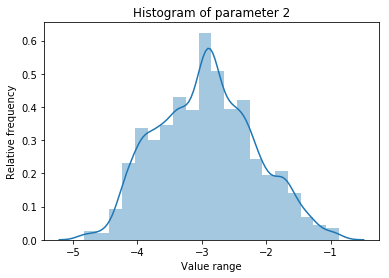

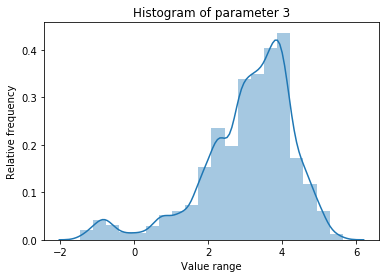

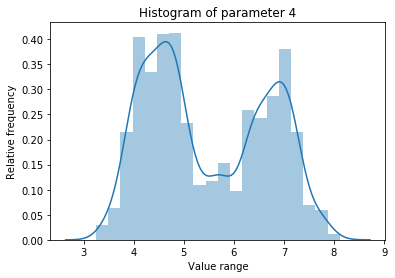

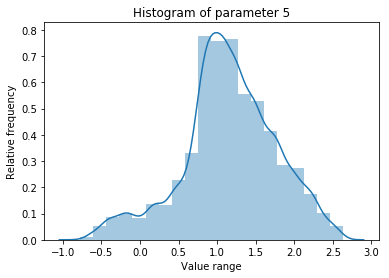

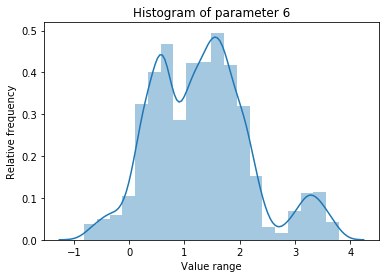

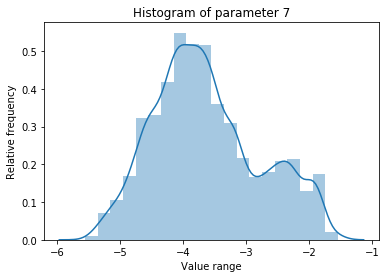

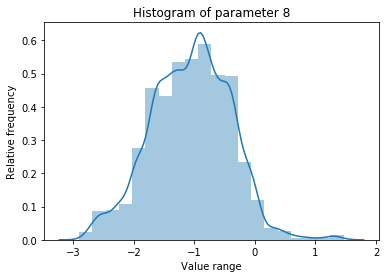

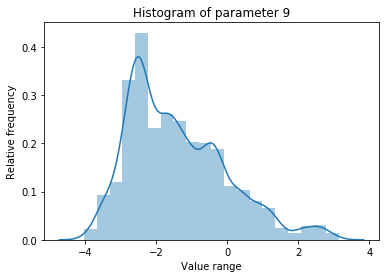

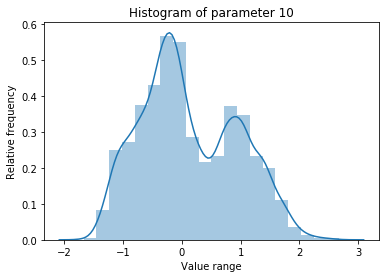

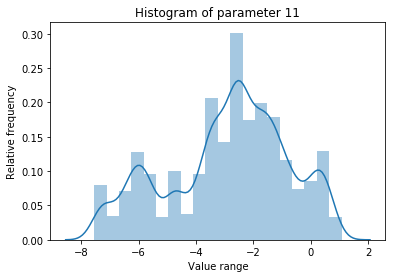

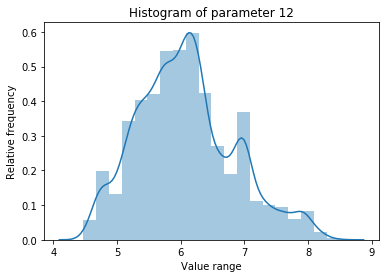

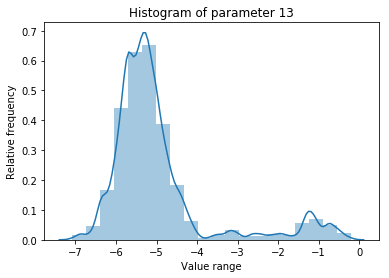

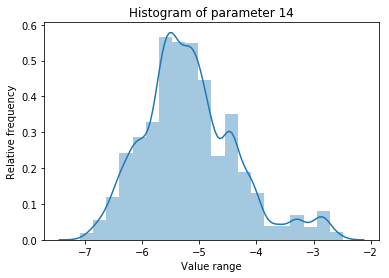

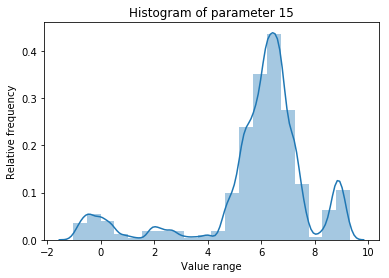

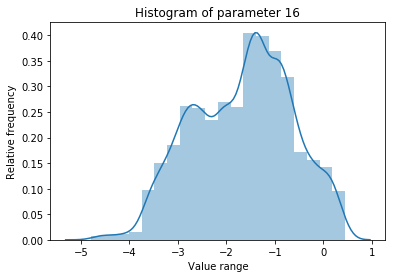

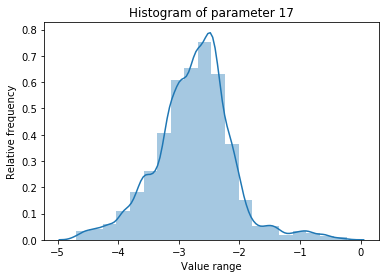

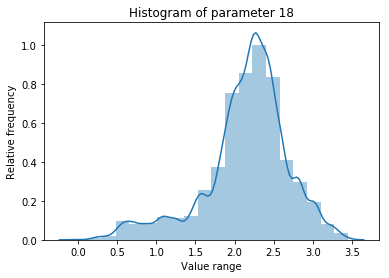

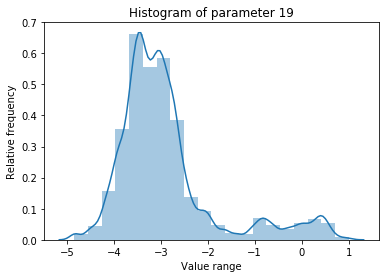

In [11]:
## Plot histograms of simulated Markov chain

for i in range(model.num_params()):
    plt.figure()
    sns.distplot(sampler.chain.get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter {}'.format(i+1))